In [1]:
# module
import pexpect
import sys
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import time
from numba import jit, f8, i8, b1, void
from sklearn.linear_model import LinearRegression

In [2]:
max_batch = 2000       #number of episode
n_step = 100           # n_step TD error, dimensionless time = 1
dim_obs = 8            # dimension of observe
dim_act  = 1           # dimension of action
dim_the   = dim_obs    # dimension of theta
gam = 0.9              # discount rate

#== important parameters ==#
batch_size = 5000            # num. of time steps with in a episode
alpha_t0 = 1e-4#/1000        # learning rate of Actor
alpha_t = alpha_t0
num_train_episode = 20       # num. of episodes for Critic
epi_fin = 500
nn=1.

In [3]:
gamma_list = [1.]
num_components=100
scaler_observe = sklearn.preprocessing.StandardScaler()
feature = sklearn.pipeline.FeatureUnion([
    (str(i), RBFSampler(gamma=gamma_list[i],
                       n_components=num_components))
    for i in range(len(gamma_list))
])

In [4]:
prc = pexpect.spawn("/bin/bash")
prc.sendline("rm action.bin")
prc.sendline("rm observe.bin")
prc.sendline("rm *pickle")

11

In [5]:
def minimize_TDerror5(obs_np,the_np,act_np,rew_np,phi_imp_np,n_step,gam,rcond=1e-15):
#====preparing samples at t and t+1 ===#
    obs0,the0,act0,phi0 = obs_np[:-n_step],the_np[:-n_step],act_np[:-n_step],phi_imp_np[:-n_step]
    obs1,the1,act1,phi1 = obs_np[n_step:], the_np[n_step:], act_np[n_step:], phi_imp_np[n_step:]


#===setting of linear EQ ===#
    p=gam*phi1-phi0
    
    rew0=np.zeros(len(rew_np)-n_step)
    gams=gam**(np.arange(n_step)/n_step)
    for n in range(len(rew0)):
        rew0[n]=np.sum(rew_np[n:n+n_step]*gams) 
    A = np.matmul(p.T,p)
    Y =-np.matmul(rew0,p)

#=== solve linear EQ ===#
    #X=np.linalg.solve(A,Y)
    A2=np.linalg.pinv(A,rcond=rcond, hermitian=True)
    X=np.matmul(A2,Y)

#=== TD error ===#
    TDerr=(((np.matmul(p,X)+rew0)**2).mean()/(np.matmul(phi0,X)**2).mean())**0.5
    print(TDerr)
    
#=== value function ===#    
    Value=np.matmul(phi0,X)
    #plt.plot(Value)
    #plt.show()

#=== policy gradient ===#
    #lr = LinearRegression(fit_intercept=True)
    #lr.fit(the0, Value)
    #dthe = lr.coef_*(1-gam**(1./n_step))   
    
    #== theta ==#
    one=np.ones(the0.shape[0]).reshape(-1,1)
    the0_expand=np.concatenate([the0, one], 1)

    #== setting of linear EQ ==#
    A = np.matmul(the0_expand.T,the0_expand)
    Y =np.matmul(Value,the0_expand)

    #=== solve linear EQ ===#
    A2=np.linalg.pinv(A,rcond=rcond, hermitian=True)
    X=np.matmul(A2,Y)
    dthe=X[:the0.shape[1]]*(1-gam**(1./n_step)) 
    
    #plt.scatter(the0[:,0]*100,the0[:,1]*100,c=Value,s=2)
    #plt.show()
    #print(the0.shape)

    #plt.plot(the0[:,0]*100)
    #plt.show()
    #print(the0.shape)
    
    #plt.plot(rew0)
    #plt.show()
    #print(the0.shape)
    
    return dthe,TDerr #w_weight,v_weight#,A,Y,X,A2

In [6]:
keep = np.fromfile('INITIAL_keep.bin', np.float64, 10000)
keep=keep.reshape(-1,2)
keep_np=np.concatenate([keep[-1],keep[-101],keep[-201],keep[-301]], 0)

In [ ]:
#=== initialization of policy parameters ===#
np.random.seed(seed=0)
the=np.zeros(dim_the)#np.random.normal(loc=0,scale=1e-1,size=dim_the)
dthe=np.zeros(dim_the)


#the=np.array([0.81443446, -0.33819061,  0.45114369,  0.15028048,  0.12500843,  0.44242219,
# -0.294206,    0.86675099])

#the=np.array([0.9634459,   2.38644134,  2.43018059, -0.99138512, -2.5555243,   0.02491551,
# -3.33367515,  0.04760289])

#===obsarvable and action===#
obs     = keep_np[:dim_obs]     # observe_t
obs_new = np.zeros(dim_obs)     # observe_{t+1}
act     = np.zeros(dim_act)     # action_t

# == history == #
J_total_history = []         # average reword within a episode
the_train_history = []       
obs_train_history = []
act_train_history = []
rew_train_history = []

total_step = 0               # total step of DNS 


TDerr,TDerr2,TDerr3 = 0,0,0
DNS_time ,Of_time,data_time,np_time,feature_time=0,0,0,0,0
Qfit1_time,Qfit2_time,Qfit3_time,gradient_time,adjust_time,update_time,plot_time,pickle_time=0,0,0,0,0,0,0,0


#========== Run the Fortran code for DNS ==========#
prc = pexpect.spawn("/bin/bash")
prc.sendline("export OMP_NUM_THREADS=4")
prc.sendline("./test.x")
#prc.logfile = sys.stdout
time.sleep(5)

#=== learning starts ===#
for i_episode in range(1, max_batch + 1):  
    total1 = time.time()##########################################################
    t1=time.time()##########################################################
    outfile = open("action.bin", 'wb')
    
    prc.sendline(str(i_episode))
    prc.expect("INPUT0", timeout=1000000)
    infile = open("observe.bin", 'rb')
    
    #=== Initialize for DNS ===#
    steps = 0 
    
    #========== Perform DNS ==========#
    while True:

        
        if i_episode <= num_train_episode+1 and steps==0 and i_episode>1:
            dthe=np.random.normal(loc=0,scale=1e-3,size=dim_the)        
        the += dthe*alpha_t
        
        #=== action from policy ===#
        act[0] = np.dot(obs,the)
        
        #=== Give action to Fortran ===#
        prc.expect("INPUT", timeout=1000000)
        outfile.write(struct.pack('<d', act[0]))
        outfile.flush()
            
        #=== Receive state from Fortran ===#    
        prc.expect("OUTPUT", timeout=1000000) 
        rew0 = struct.unpack('<d', infile.read(8))[0]
                
        for i in range(dim_obs):
            obs_new[i]=struct.unpack('<d', infile.read(8))[0]
        
        #=== reward ===#
        rew=rew0 

        #=== for history ===#
        the_train_history.append(np.array(the)) # Save total history of theta (not good)
        obs_train_history.append(np.array(obs)) # Save total history of observe_t
        act_train_history.append(np.array(act)) # Save total history of action_t
        rew_train_history.append(np.array(rew)) # save history of reward_{t+1}
        
        #=== time evolution ===#
        obs = obs_new  
        steps += 1; total_step += 1
        
        #=== Termination conditions for DNS ===#
        if steps >= batch_size:
            break
                
    prc.expect("END", timeout=1000000)
    outfile.close(); infile.close()
    t2=time.time()##########################################################
    DNS_time=t2-t1##########################################################
    
#=== Object function ===#
    t1=time.time()##########################################################
    J=np.mean(np.array(rew_train_history)[-batch_size:])
    J_total_history.append(J)
    t2=time.time()##########################################################
    Of_time=t2-t1##########################################################
    
#==== training data ====#    
    t1=time.time()##########################################################
    if len(obs_train_history)==batch_size*(num_train_episode+1):
        del obs_train_history[:batch_size]
        del rew_train_history[:batch_size]
        del the_train_history[:batch_size]
        del act_train_history[:batch_size]
    print("check", np.array(rew_train_history).shape)
    t2=time.time()##########################################################
    data_time=t2-t1##########################################################
    

#========= start of RL =========#    
    if i_episode >= num_train_episode+1:
        t1=time.time()##########################################################
        obs_np=np.array(obs_train_history)
        rew_np=np.array(rew_train_history)
        the_np=np.array(the_train_history)
        act_np=np.array(act_train_history)
        t2=time.time()##########################################################
        np_time=t2-t1##########################################################

#========= Feature values =========# 
        t1=time.time()##########################################################
        #print('episode for phi',obs_np[-batch_size:].shape)
        
        obs_the_np=np.concatenate([obs_np, the_np], 1)
        #obs_the_scale_np = (obs_the_np - obs_the_np.mean(0)) / obs_the_np.std(0)
        phi_imp_np = feature.fit_transform(obs_the_np)
        t2=time.time()##########################################################
        feature_time=t2-t1##########################################################
    
#==== fitting of value function====#         
        t1=time.time()##########################################################
        dthe,TDerr=minimize_TDerror5(obs_np,the_np,act_np,rew_np,phi_imp_np,n_step,gam)
        t2=time.time()##########################################################
        Qfit3_time=t2-t1##########################################################
        #alpha_t=0.001/TDerr*10.**(-6)
        #print("differ",((w_weight-w_weight2)**2).max(),((v_weight-v_weight2)**2).max())  
        #alpha_t=alpha_t0-alpha_t0/epi_fin * (i_episode-num_train_episode) #1e-4/TDerr*alpha_t_base
        #alpha_t=alpha_t0 * ( 1/(i_episode-num_train_episode)**nn - 1/(epi_fin+1)**nn ) * (epi_fin+1)**nn / ((epi_fin+1)**nn -1)
        #if alpha_t < 0: #i_episode > 13:#
        #    alpha_t=0
        #if(i_episode==520 or i_episode==1020 or i_episode==1520):
        #    alpha_t=alpha_t/10
        
#=== plot of obserbation and objective function===#
    t1=time.time()##########################################################
    plt.plot(obs_train_history[-batch_size:]); plt.show()
    plt.plot(J_total_history); plt.show()
    t2=time.time()##########################################################
    plot_time=t2-t1##########################################################

#=== save of trajectries ===#
    t1=time.time()##########################################################
    with open('obs.pickle', 'wb') as f:
        pickle.dump(obs_train_history,f)
    with open('act.pickle', 'wb') as f:
        pickle.dump(act_train_history,f)
    with open('J.pickle', 'wb') as f:
        pickle.dump(J_total_history,f)
    with open('the.pickle', 'wb') as f:
        pickle.dump(the_train_history,f)
    with open('rew.pickle', 'wb') as f:
        pickle.dump(rew_train_history,f)
    t2=time.time()##########################################################
    pickle_time=t2-t1##########################################################
    
#=== display ===#        
    print("#====================",i_episode, " episode ====================#")
    print("J       = ", J           )
    print("dtheta  = ", dthe        )
    print("theta   = ", the         )
    print("TDerr   = ", TDerr       )
    print("alpha_t = ", alpha_t     )
    #print("w       = ", w_weight)
    #print("v       = ", v_weight)
    
#=== elapse time ===#   
    print("#==================== TIME ====================#")
    print("DNS              : ", DNS_time       )
    print("Object function  : ", Of_time        )
    print("Train data       : ", data_time      )
    print("Create numpy     : ", np_time        )
    print("Feature          : ", feature_time   )
    print("Q fit            : ", Qfit3_time     )
    print("Plot             : ", plot_time      )
    print("Pickle           : ", pickle_time    )
    total2 = time.time()##########################################################
    print("#=============================================#")
    print("TOTAL TIME per minibatch : ", total2-total1  )

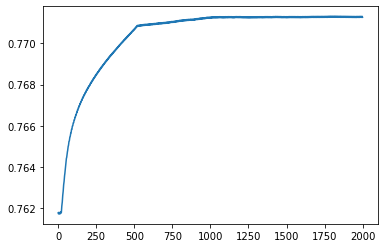

In [7]:
with open('J.pickle','rb') as f:
        J2=np.array(pickle.load(f))
plt.plot(J2)